In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
import torch
import torch.nn as nn
from torchmetrics.classification import BinaryRecall, BinaryAccuracy, BinaryF1Score, BinaryPrecision

In [16]:
dataset = pd.read_csv('diabetes_data.csv')

In [17]:
dataset

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0
4,8.0,0.0,0.0,1.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,6.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0
70688,10.0,1.0,1.0,1.0,29.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0
70689,13.0,0.0,1.0,1.0,25.0,0.0,1.0,0.0,1.0,0.0,0.0,5.0,15.0,0.0,1.0,0.0,1.0,1.0
70690,11.0,0.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,1.0


In [18]:
dataset.isnull().sum()

Age                     0
Sex                     0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Stroke                  0
HighBP                  0
Diabetes                0
dtype: int64

In [19]:
outliers_removed = False

In [20]:
def numerical_data_analysis(column_name):
  global outliers_removed, dataset
  """Given the column name, plot the histogram to recognize the distribution and a boxplot to see if there are any
  outliers (Only for observation, not cleaning), show quantitve measures and remove outliers (if existed).

  Parameters:
  ----------
  column_name (str): column name from the dataset

  Returns:
  ----------
  None
  """
  fig = plt.figure(figsize=(10, 10))
  fig.suptitle(column_name, fontsize=16)
  ax_1 = fig.add_subplot(121)
  ax_1.hist(dataset[column_name], bins=10)
  ax_1.set_xlabel(column_name)
  ax_1.set_ylabel('frequency')


  if dataset[column_name].nunique() > 10:

    ax_2 = fig.add_subplot(122)
    ax_2.boxplot(dataset[column_name])
    ax_2.set_xticks([1], [column_name])
    ax_2.set_ylabel('Value')
    plt.show()
    Q3 = np.quantile(dataset[column_name], 0.75)
    Q1 = np.quantile(dataset[column_name], 0.25)
    IQR = Q3 - Q1
    print(f'First quartile: {Q1}')
    print(f"Third quartile: {Q3}")
    print(f'Interquartile range: {IQR}')
    print(f'Max value of the column: {dataset[column_name].max()}')
    print(f'Min value of the column: {dataset[column_name].min()}')
    print(f'Most frequent value of the column: {dataset[column_name].mode()[0]}')
    print(f'Mean of the column: {dataset[column_name].mean()}')
    print(f'Median of the column: {dataset[column_name].median()}')
    dataset[column_name] = (dataset[column_name] - dataset[column_name].min()) / (dataset[column_name].max() - dataset[column_name].min())
    print("----------------------------------------")
  else:
    ax_2 = fig.add_subplot(122)
    ax_2.pie(dataset[column_name].value_counts().sort_index(), labels=np.arange(dataset[column_name].min(), dataset[column_name].max() + 1), autopct='%1.0f%%')

    plt.show()
    print(f'Max value of the column: {dataset[column_name].max()}')
    print(f'Min value of the column: {dataset[column_name].min()}')
    print(f'Most frequent value of the column: {dataset[column_name].mode()[0]}')
    print("----------------------------------------")

In [21]:
def exploratory_data_analysis(data: pd.DataFrame):
  if len(data) != 0:
    dtypes = data.dtypes
    for column in data.columns:
      numerical_data_analysis(column_name=column)
      print("\n\n\n\n")

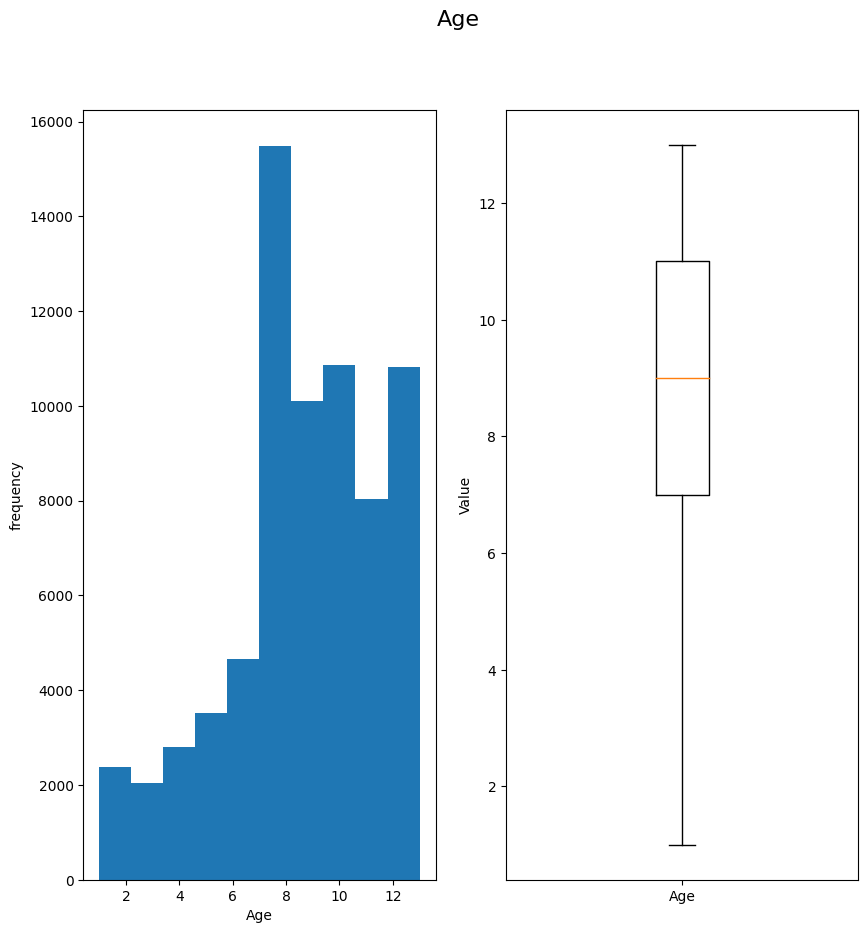

First quartile: 7.0
Third quartile: 11.0
Interquartile range: 4.0
Max value of the column: 13.0
Min value of the column: 1.0
Most frequent value of the column: 10.0
Mean of the column: 8.584054772817291
Median of the column: 9.0
----------------------------------------







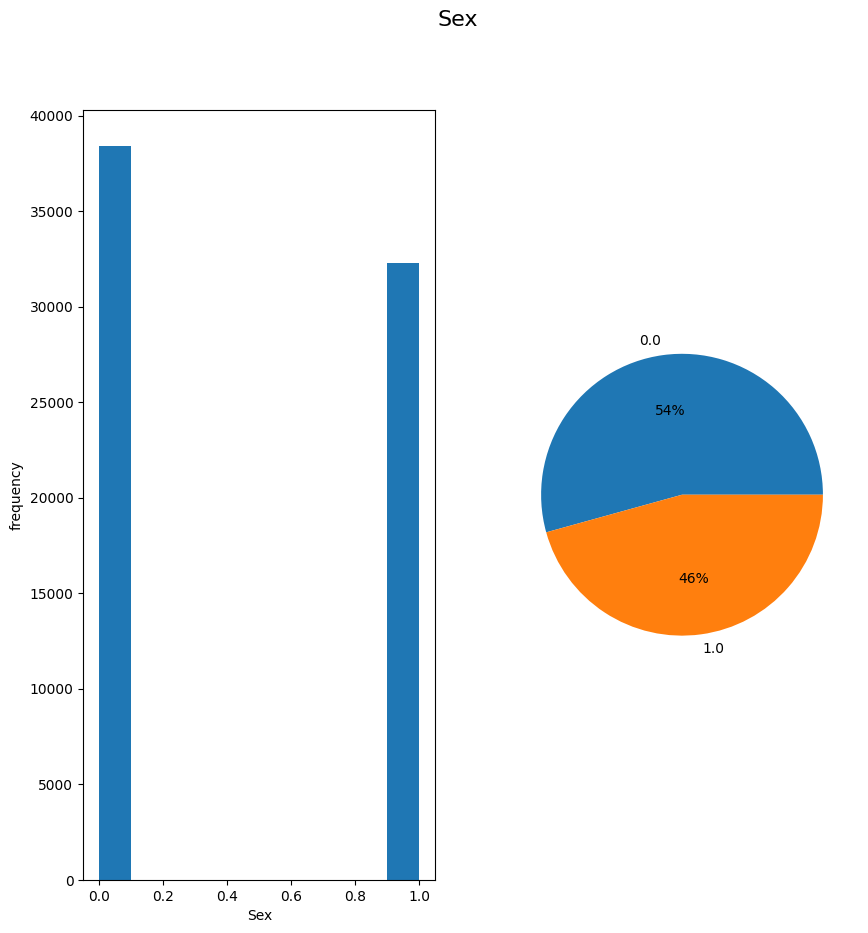

Max value of the column: 1.0
Min value of the column: 0.0
Most frequent value of the column: 0.0
----------------------------------------







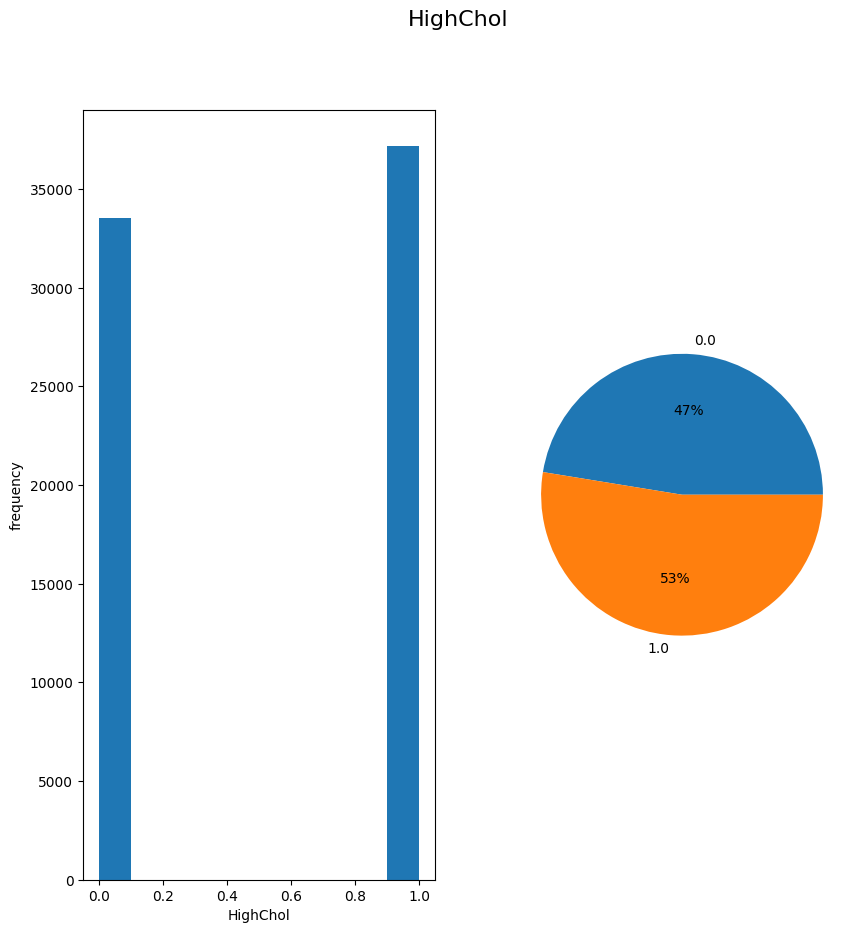

Max value of the column: 1.0
Min value of the column: 0.0
Most frequent value of the column: 1.0
----------------------------------------







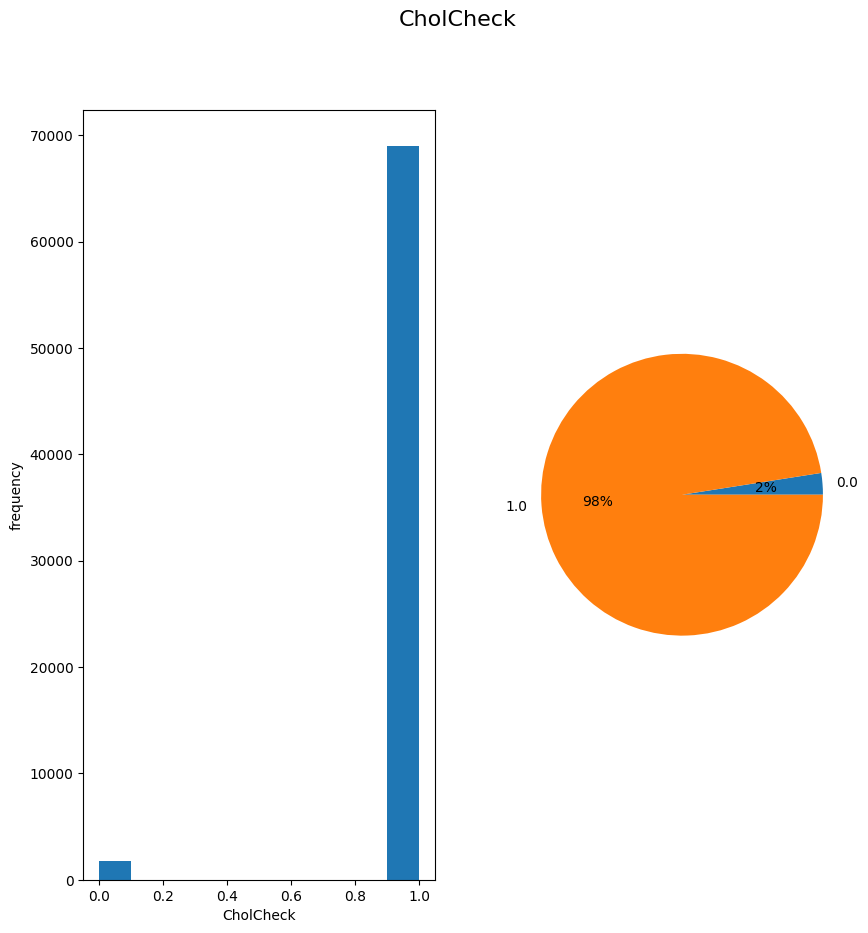

Max value of the column: 1.0
Min value of the column: 0.0
Most frequent value of the column: 1.0
----------------------------------------







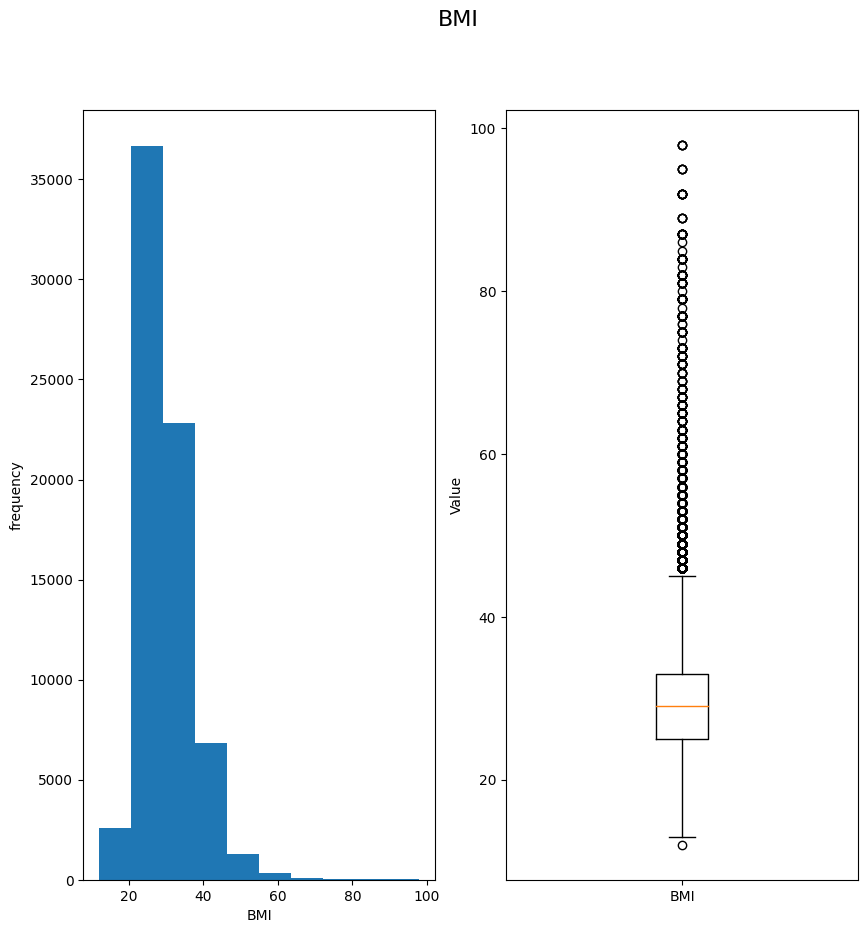

First quartile: 25.0
Third quartile: 33.0
Interquartile range: 8.0
Max value of the column: 98.0
Min value of the column: 12.0
Most frequent value of the column: 27.0
Mean of the column: 29.856985231709388
Median of the column: 29.0
----------------------------------------







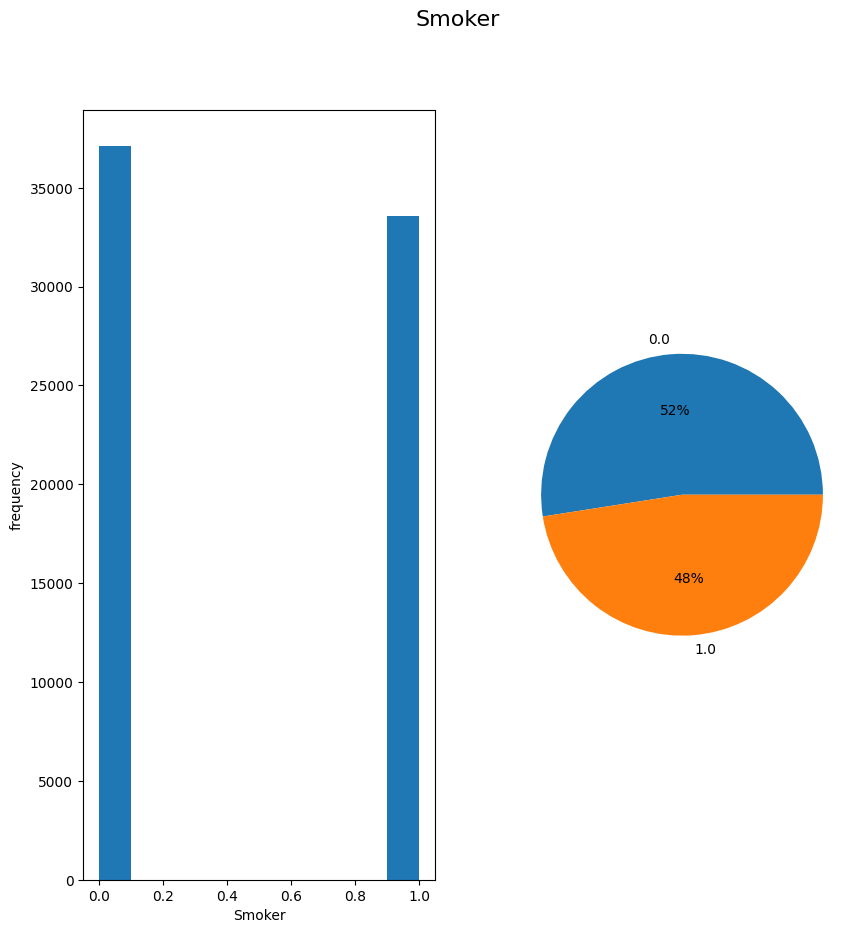

Max value of the column: 1.0
Min value of the column: 0.0
Most frequent value of the column: 0.0
----------------------------------------







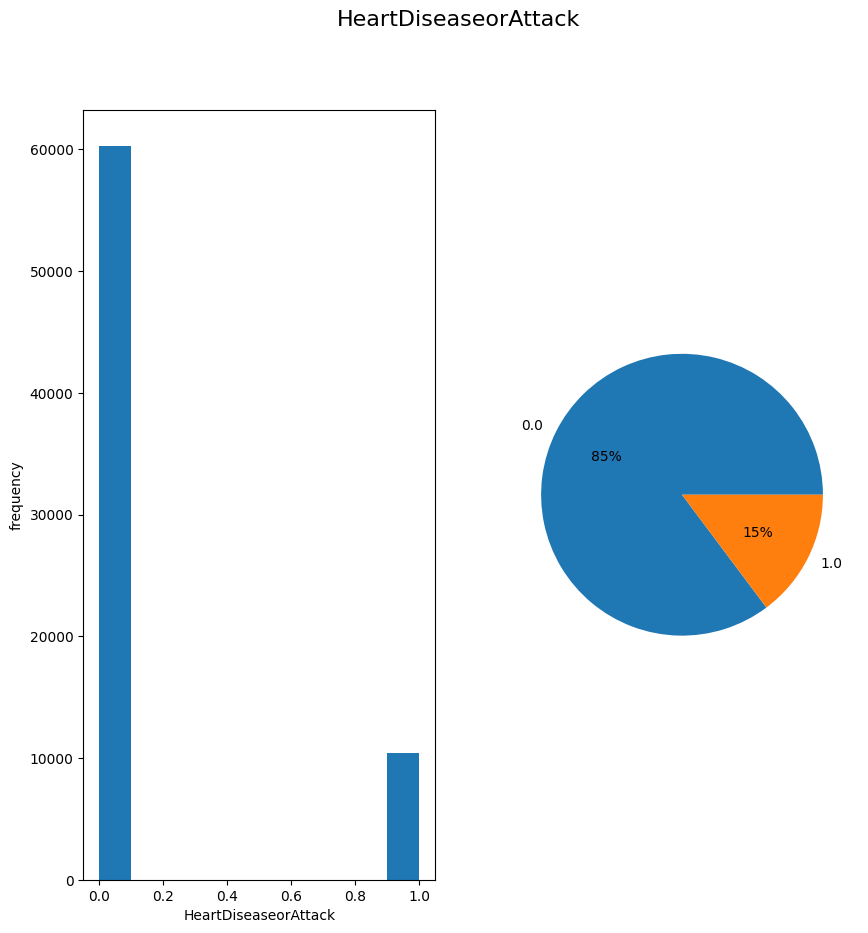

Max value of the column: 1.0
Min value of the column: 0.0
Most frequent value of the column: 0.0
----------------------------------------







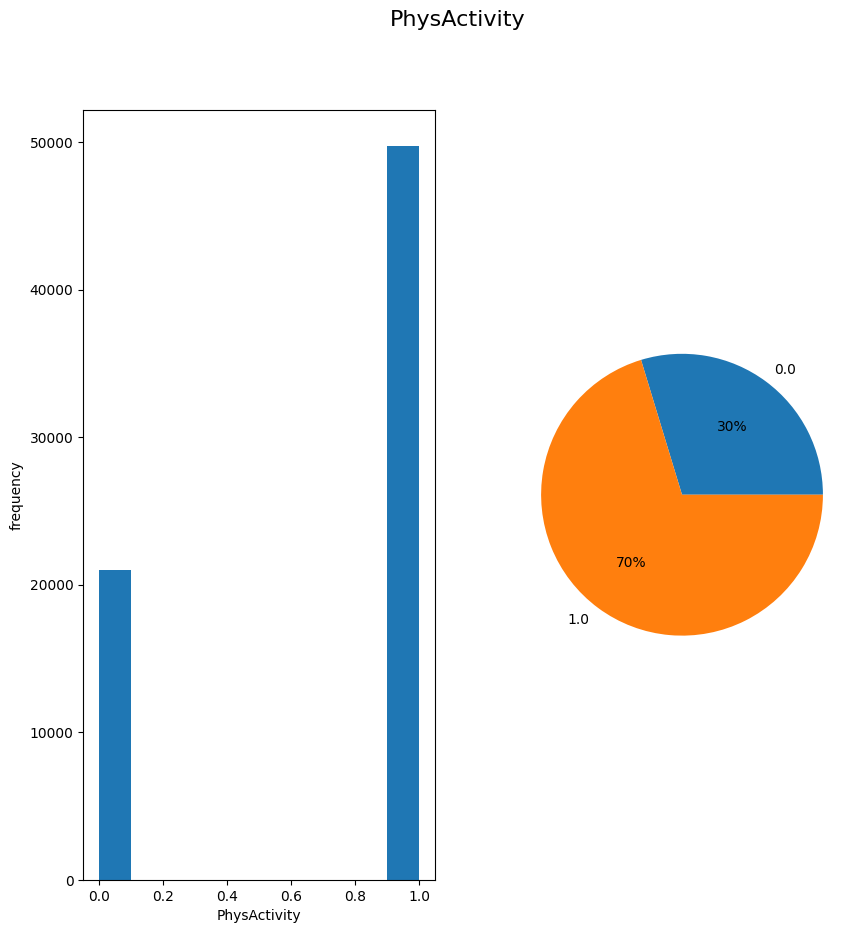

Max value of the column: 1.0
Min value of the column: 0.0
Most frequent value of the column: 1.0
----------------------------------------







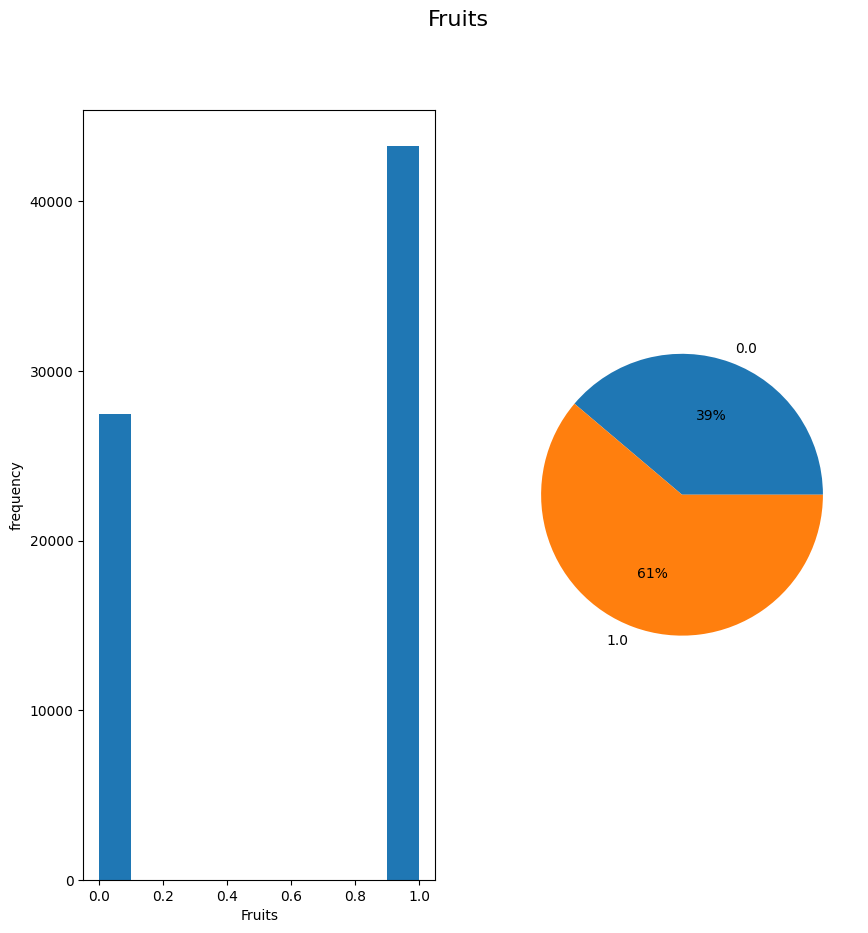

Max value of the column: 1.0
Min value of the column: 0.0
Most frequent value of the column: 1.0
----------------------------------------







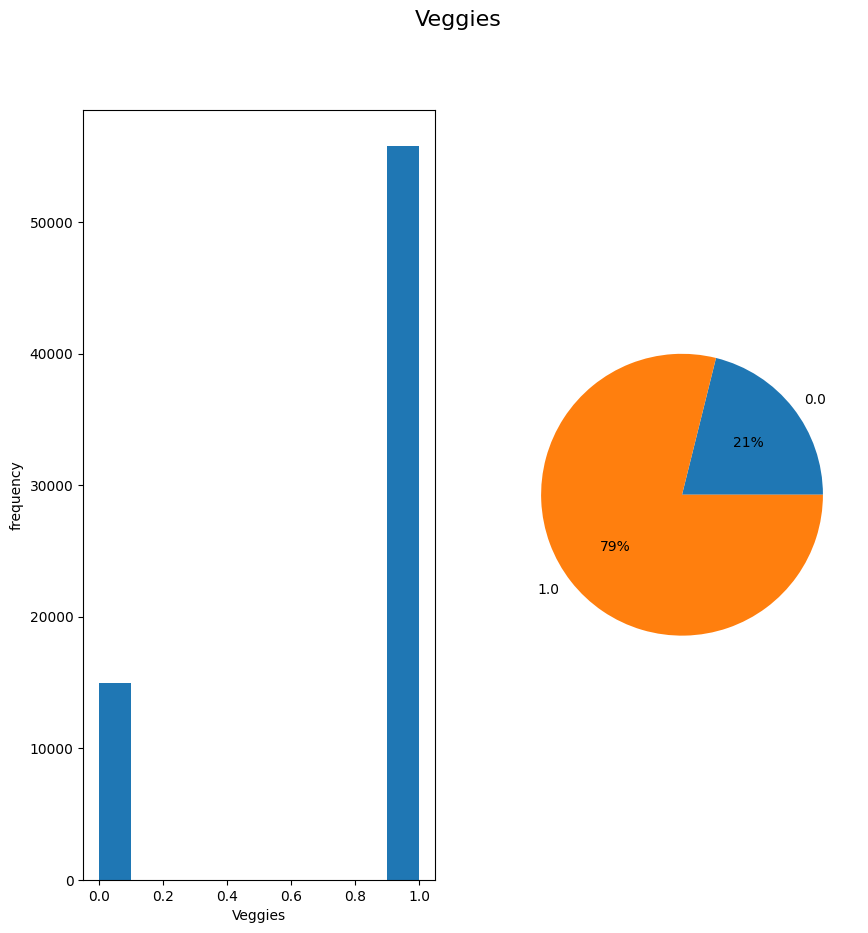

Max value of the column: 1.0
Min value of the column: 0.0
Most frequent value of the column: 1.0
----------------------------------------







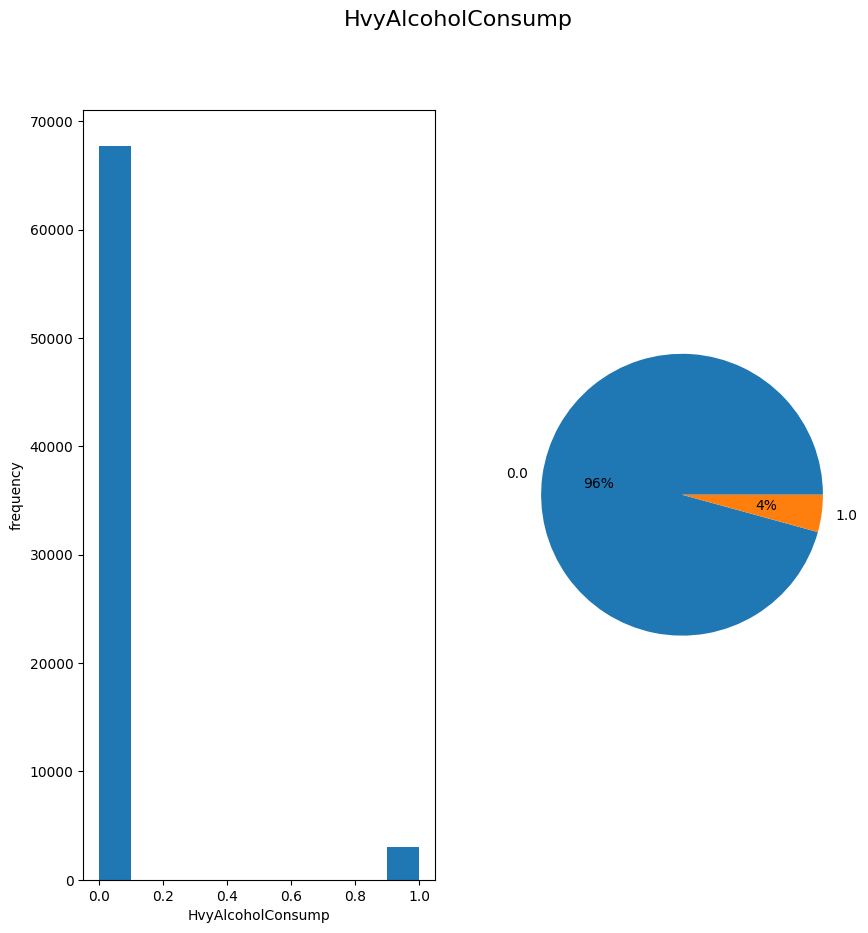

Max value of the column: 1.0
Min value of the column: 0.0
Most frequent value of the column: 0.0
----------------------------------------







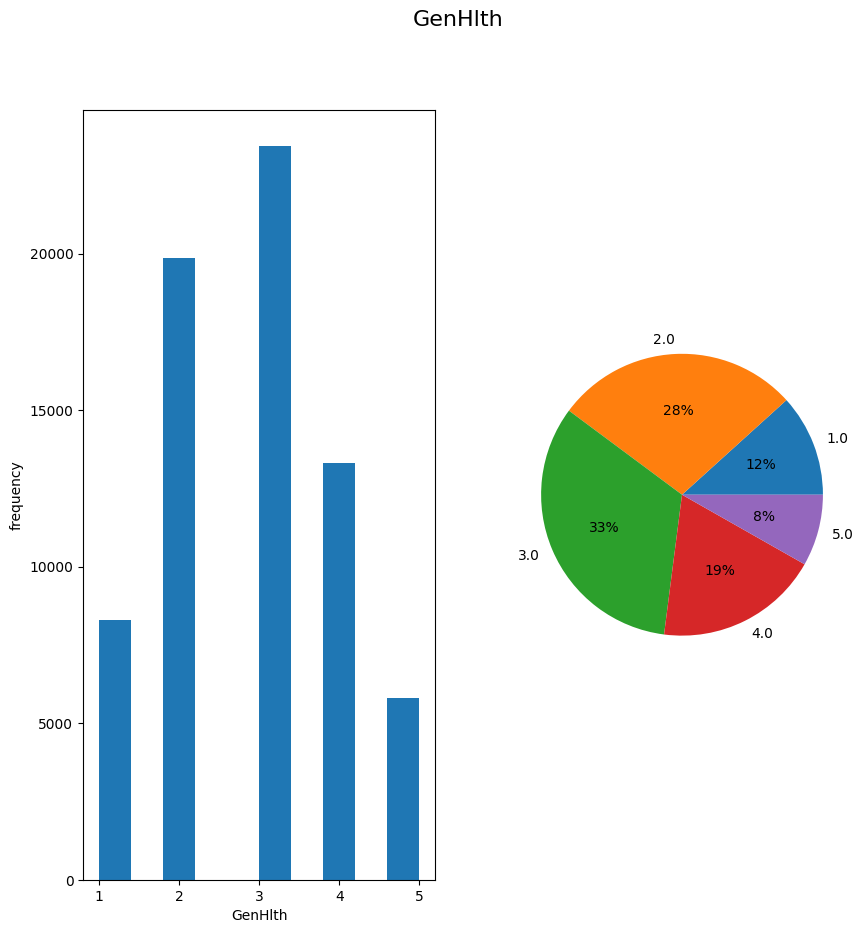

Max value of the column: 5.0
Min value of the column: 1.0
Most frequent value of the column: 3.0
----------------------------------------







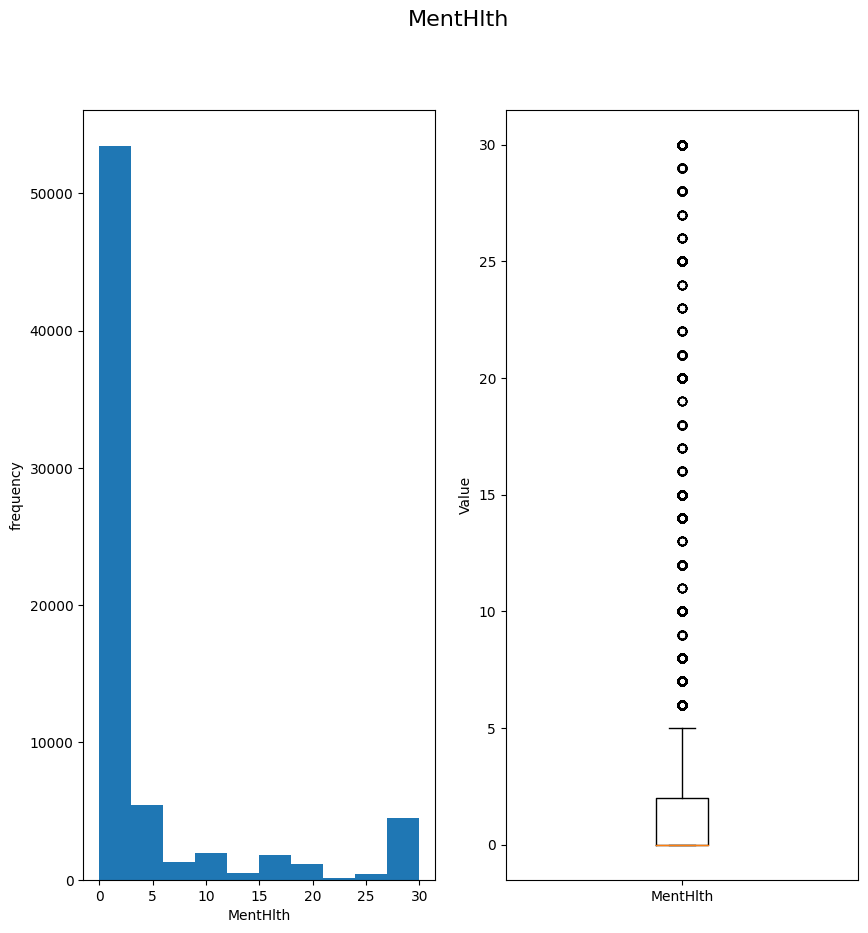

First quartile: 0.0
Third quartile: 2.0
Interquartile range: 2.0
Max value of the column: 30.0
Min value of the column: 0.0
Most frequent value of the column: 0.0
Mean of the column: 3.7520370056017653
Median of the column: 0.0
----------------------------------------







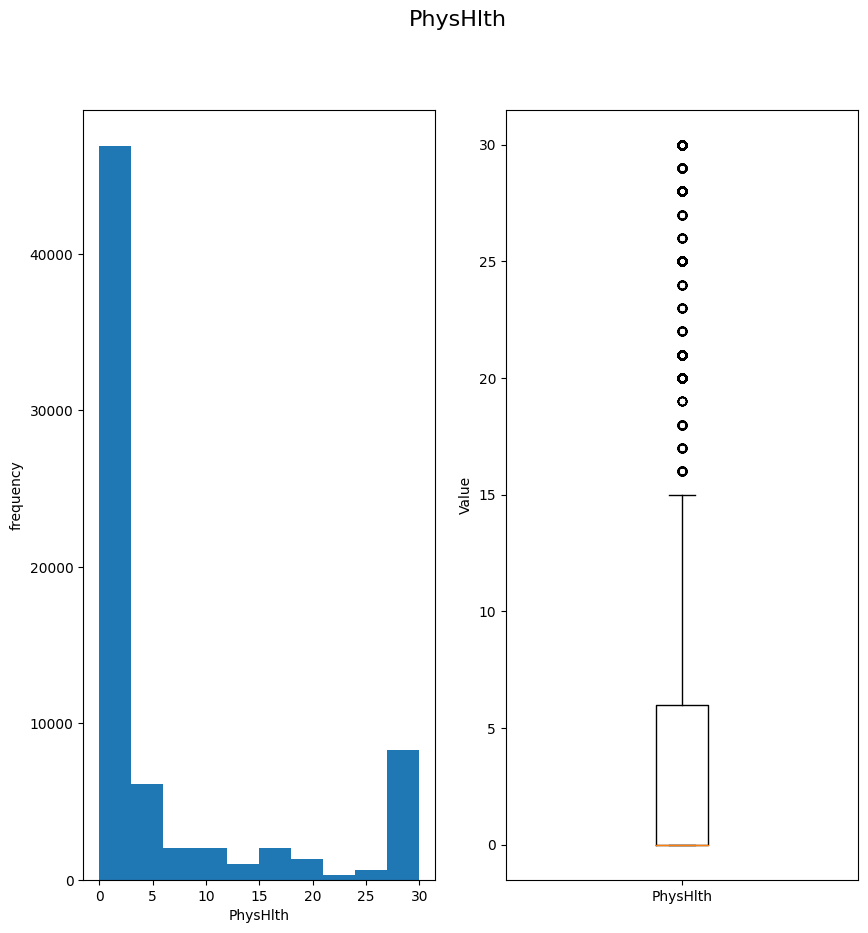

First quartile: 0.0
Third quartile: 6.0
Interquartile range: 6.0
Max value of the column: 30.0
Min value of the column: 0.0
Most frequent value of the column: 0.0
Mean of the column: 5.810417020313473
Median of the column: 0.0
----------------------------------------







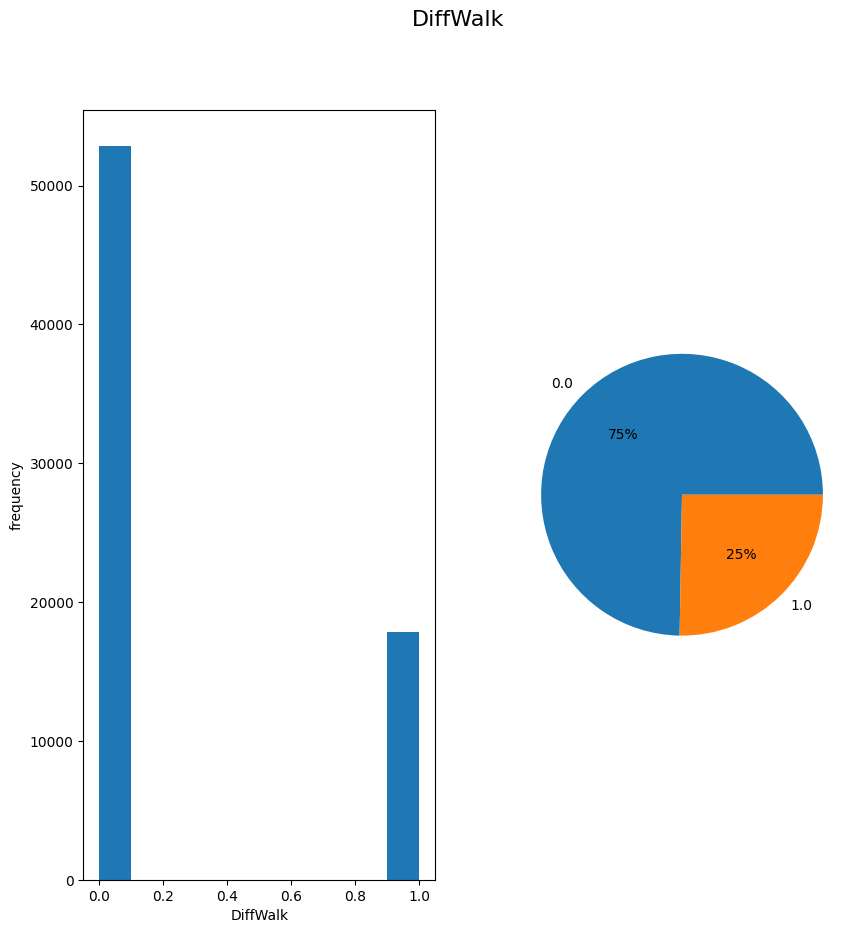

Max value of the column: 1.0
Min value of the column: 0.0
Most frequent value of the column: 0.0
----------------------------------------







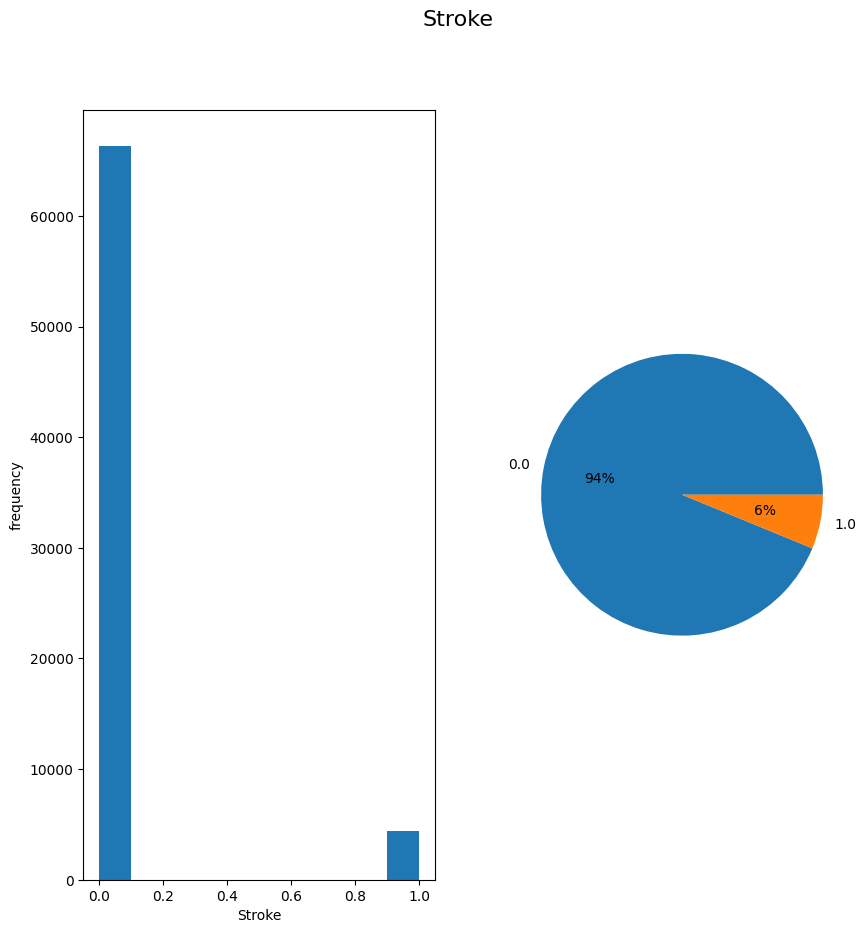

Max value of the column: 1.0
Min value of the column: 0.0
Most frequent value of the column: 0.0
----------------------------------------







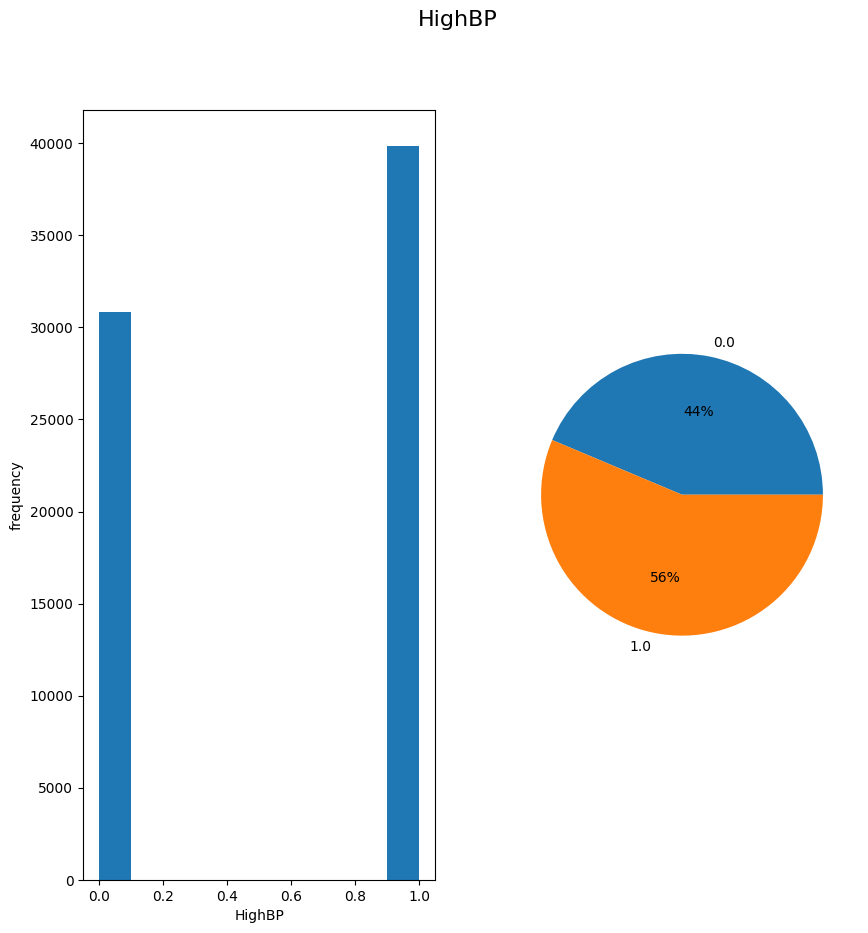

Max value of the column: 1.0
Min value of the column: 0.0
Most frequent value of the column: 1.0
----------------------------------------







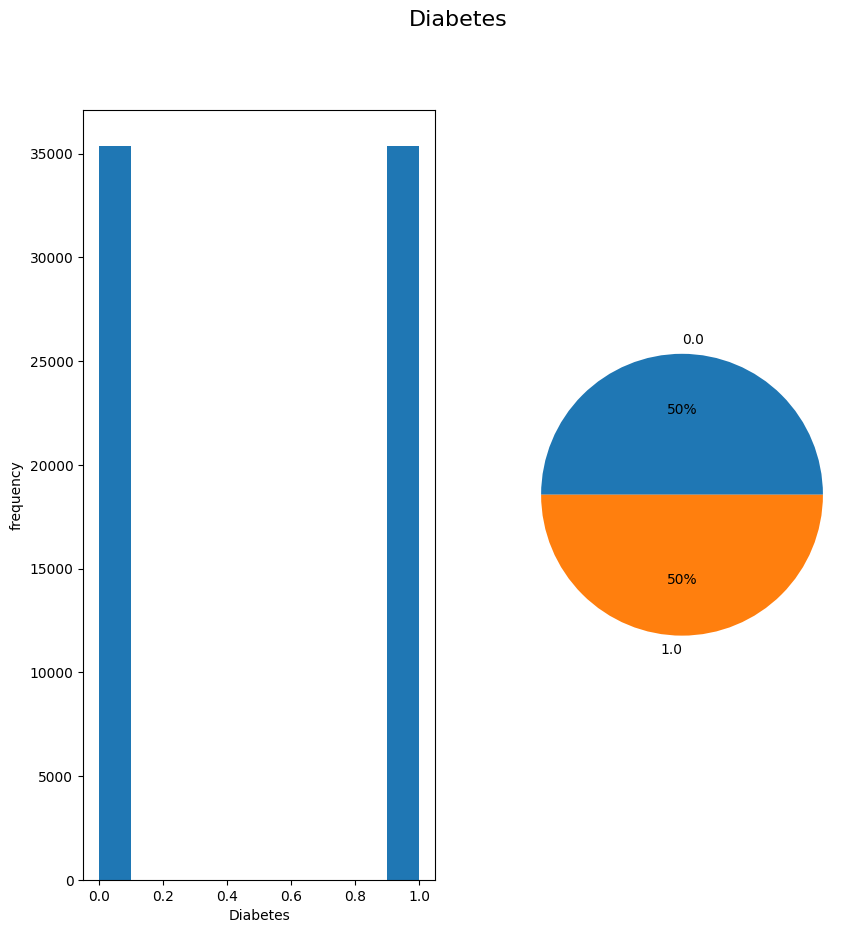

Max value of the column: 1.0
Min value of the column: 0.0
Most frequent value of the column: 0.0
----------------------------------------







In [22]:
exploratory_data_analysis(dataset)

In [23]:
X, y = dataset.drop('Diabetes', axis=1).values, dataset[['Diabetes']].values.reshape(-1, )

In [24]:
X.shape, y.shape

((70692, 17), (70692,))

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5)

In [26]:
knn_1 = KNeighborsClassifier(n_neighbors=1)
knn_1.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [27]:
print(f"Accuracy score for KNN model with n_neighbors=1: {accuracy_score(y_validation, knn_1.predict(X_validation))}")
print(f"Recall score for KNN model with n_neighbors=1: {recall_score(y_validation, knn_1.predict(X_validation))}")
print(f"Precision score for KNN model with n_neighbors=1: {precision_score(y_validation, knn_1.predict(X_validation))}")
print(f"F1 score for KNN model with n_neighbors=1: {f1_score(y_validation, knn_1.predict(X_validation))}")

Accuracy score for KNN model with n_neighbors=1: 0.6632248939179632
Recall score for KNN model with n_neighbors=1: 0.6622572473965663
Precision score for KNN model with n_neighbors=1: 0.6658177702320317
F1 score for KNN model with n_neighbors=1: 0.6640327359954847


In [28]:
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [29]:
print(f"Accuracy score for KNN model with n_neighbors=3: {accuracy_score(y_validation, knn_3.predict(X_validation))}")
print(f"Recall score for KNN model with n_neighbors=3: {recall_score(y_validation, knn_3.predict(X_validation))}")
print(f"Precision score for KNN model with n_neighbors=3: {precision_score(y_validation, knn_3.predict(X_validation))}")
print(f"F1 score for KNN model with n_neighbors=3: {f1_score(y_validation, knn_3.predict(X_validation))}")

Accuracy score for KNN model with n_neighbors=3: 0.6905233380480905
Recall score for KNN model with n_neighbors=3: 0.7103855896425556
Precision score for KNN model with n_neighbors=3: 0.6853108878631551
F1 score for KNN model with n_neighbors=3: 0.6976229961304589


In [30]:
param_grid = {
     'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}



In [31]:
xgb_classifier = xgb.XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, n_jobs=-1, scoring='recall')
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='recall')

In [32]:
best_model = grid_search.best_estimator_

In [33]:
print(f"Accuracy score for best XGBoost model: {accuracy_score(y_validation, best_model.predict(X_validation))}")
print(f"Recall score for best XGBoost model: {recall_score(y_validation, best_model.predict(X_validation))}")
print(f"Precision score for best XGBoost model: {precision_score(y_validation, best_model.predict(X_validation))}")
print(f"F1 score for best XGBoost model: {f1_score(y_validation, best_model.predict(X_validation))}")

Accuracy score for best XGBoost model: 0.7138613861386138
Recall score for best XGBoost model: 0.8376020264565156
Precision score for best XGBoost model: 0.6729986431478969
F1 score for best XGBoost model: 0.7463322884012539


In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [35]:
class ANN_model_1(nn.Module):
  def __init__(self, in_shape, out_shape, hidden_units):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Linear(in_features=in_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units * 2),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units * 2, out_features=out_shape),
        nn.Sigmoid(),
    )
  def forward(self, X):
    return self.layer_stack(X)
model_1 = ANN_model_1(X_train.shape[1], 1, 10).to(device)

In [36]:
loss_function = nn.BCELoss()

optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(device)

In [37]:
epochs = 200

for epoch in range(epochs):
  model_1.train()

  y_pred = model_1(X_train_tensor)

  loss = loss_function(y_pred, y_train_tensor)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()



In [38]:
X_validation_tensor = torch.tensor(X_validation, dtype=torch.float32).to(device)
y_validation_tensor = torch.tensor(y_validation.reshape(-1, 1), dtype=torch.float32).to(device)

In [39]:
with torch.inference_mode():
  model_1.eval()
  recall_metric = BinaryRecall().to(device)
  accuracy_metric = BinaryAccuracy().to(device)
  f1_score_metric = BinaryF1Score().to(device)
  precision_metric = BinaryPrecision().to(device)

  y_pred = model_1(X_validation_tensor)
  print(f'Recall for First NN model: {recall_metric(y_pred, y_validation_tensor)}')
  print(f'Precision for First NN model: {precision_metric(y_pred, y_validation_tensor)}')
  print(f'F1 score for First NN model: {f1_score_metric(y_pred, y_validation_tensor)}')
  print(f'Accuracy for First NN model: {accuracy_metric(y_pred, y_validation_tensor)}')



Recall for First NN model: 0.9555305242538452
Precision for First NN model: 0.5611570477485657
F1 score for First NN model: 0.7070707082748413
Accuracy for First NN model: 0.6021216511726379


In [40]:
class ANN_model_2(nn.Module):
  def __init__(self, in_shape, out_shape, hidden_units):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Linear(in_features=in_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units * 4),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units * 4, out_features=hidden_units * 4),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units * 4, out_features=out_shape),
        nn.Sigmoid(),
    )
  def forward(self, X):
    return self.layer_stack(X)
model_2 = ANN_model_2(X_train.shape[1], 1, 10).to(device)

In [41]:
loss_function = nn.BCELoss()

optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)


In [42]:
epochs = 100

for epoch in range(epochs):
  model_2.train()

  y_pred = model_2(X_train_tensor)

  loss = loss_function(y_pred, y_train_tensor)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

In [43]:
with torch.inference_mode():
  model_2.eval()
  recall_metric = BinaryRecall().to(device)
  accuracy_metric = BinaryAccuracy().to(device)
  f1_score_metric = BinaryF1Score().to(device)
  precision_metric = BinaryPrecision().to(device)

  y_pred = model_2(X_validation_tensor)
  print(f'Recall for Second NN model: {recall_metric(y_pred, y_validation_tensor)}')
  print(f'Precision for Second NN model: {precision_metric(y_pred, y_validation_tensor)}')
  print(f'F1 score for Second NN model: {f1_score_metric(y_pred, y_validation_tensor)}')
  print(f'Accuracy for Second NN model: {accuracy_metric(y_pred, y_validation_tensor)}')



Recall for Second NN model: 1.0
Precision for Second NN model: 0.502545952796936
F1 score for Second NN model: 0.668925940990448
Accuracy for Second NN model: 0.502545952796936


In [136]:
torch.manual_seed(42)
class ANN_model_3(nn.Module):
  def __init__(self, in_shape, out_shape, hidden_units):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Linear(in_features=in_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units * 4),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units * 4, out_features=hidden_units * 8),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units * 8, out_features=hidden_units * 8),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units * 8, out_features=out_shape),
        nn.Sigmoid()
    )
  def forward(self, X):
    return self.layer_stack(X)
model_3 = ANN_model_3(X_train.shape[1], 1, 10).to(device)

In [137]:
loss_function = nn.BCELoss()

optimizer = torch.optim.Adam(params=model_3.parameters(), lr=0.01)


In [138]:
torch.manual_seed(42)
epochs = 200

for epoch in range(epochs):
  model_3.train()

  y_pred = model_3(X_train_tensor)

  loss = loss_function(y_pred, y_train_tensor)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

In [139]:
with torch.inference_mode():
  model_3.eval()
  recall_metric = BinaryRecall().to(device)
  accuracy_metric = BinaryAccuracy().to(device)
  f1_score_metric = BinaryF1Score().to(device)
  precision_metric = BinaryPrecision().to(device)

  y_pred = model_3(X_validation_tensor)
  print(f'Recall for third NN model: {recall_metric(y_pred, y_validation_tensor)}')
  print(f'Precision for third NN model: {precision_metric(y_pred, y_validation_tensor)}')
  print(f'F1 score for third NN model: {f1_score_metric(y_pred, y_validation_tensor)}')
  print(f'Accuracy for third NN model: {accuracy_metric(y_pred, y_validation_tensor)}')



Recall for third NN model: 0.8167745471000671
Precision for third NN model: 0.7135480642318726
F1 score for third NN model: 0.7616797685623169
Accuracy for third NN model: 0.7431400418281555
